In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy
from scipy import optimize as op
import corner
import os
os.environ["OMP_NUM_THREADS"] = "8"
from multiprocessing import Pool
import time
from datetime import datetime 

from scipy.optimize import minimize

In [2]:
c=cte.c
c_um=c.to("um/s")
c_mm=c.to("mm/s")

c = c.value # m/s

Msun=cte.M_sun
Msun = Msun.value # kg

h = cte.h.value

K=cte.k_B.value

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/book2.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

z=[]

S3=[]
errS3=[]

S2=[]
errS2=[]

S1=[]
errS1=[]

S870=[]
errS870=[]

S500=[]
errS500=[]

S350=[]
errS350=[]

S250=[]
errS250=[]

S160=[]
errS160=[]

S100=[]
errS100=[]

for j in rows:   
    
    ID.append(j[0])
    z.append(float(j[1]))
    S3.append(float(j[2]))
    errS3.append(float(j[3]))
    S2.append(float(j[4]))
    errS2.append(float(j[5]))
    S1.append(float(j[6]))
    errS1.append(float(j[7]))
    S870.append(float(j[8]))
    errS870.append(float(j[9]))
    S500.append(float(j[10]))
    errS500.append(float(j[11]))
    S350.append(float(j[12]))
    errS350.append(float(j[13]))
    S250.append(float(j[14]))
    errS250.append(float(j[15]))
    S160.append(float(j[16]))
    errS160.append(float(j[17]))
    S100.append(float(j[18]))
    errS100.append(float(j[19]))
   

In [4]:
v__=np.array([500,350,250,160,100])*un.um
v_=(c_um/v__).to("Hz")
v=v_.value
l__=np.array([95,150,220])*un.GHz
l_=l__.to("Hz")
l=l_.value
vf=np.concatenate((l,v))
print(vf)

[9.50000000e+10 1.50000000e+11 2.20000000e+11 5.99584916e+11
 8.56549880e+11 1.19916983e+12 1.87370286e+12 2.99792458e+12]


In [5]:
frecsT_l=[]
errfT_l=[]
for m in range (len(rows)):
    
    frec=[S3[m],S2[m],S1[m],S500[m],S350[m],S250[m],S160[m],S100[m]]
    errf=[errS3[m],errS2[m],errS1[m],errS500[m],errS350[m],errS250[m],errS160[m],errS100[m]]
    frecsT_l.append(frec)
    errfT_l.append(errf)

In [6]:
def clean(a,b):
    fr_=[] # lista de frecuencias corregidas
    er_=[] # lista de errores corregidos
    f=[] 
    e=[]
    inf=[] # indice frecs
    ine=[] # indice err
    for x in a:
        inf_=[]
        f_=[]
        for m in x:
            if np.isnan(m)==True:
                indice=x.index(m)
                inf_.append(indice)
                newf=list(np.delete(x,indice))
                f_.append(newf)
            else:
                f_.append(x)
        inf.append(inf_)
        
        fr=[]
        
        for j in range (len(f_)-1):
            if f_[j]!=f_[j+1] and f_[j] not in fr:
                fr.append(f_[j])
            if f_[j]==f_[j+1] and f_[j] not in fr:
                fr.append(f_[j])
                
        fr_.append(fr)
    
    
    
    
    for y in b:
        ine_=[]
        e_=[]
        for n in y:
            if np.isnan(n)==True:
                indice=y.index(n)
                ine_.append(indice)
                newe=list(np.delete(y,indice))
                e_.append(newe)
            else:
                e_.append(y)
        ine.append(ine_)
        
        er=[]
        
        for j in range (len(e_)-1):
            if e_[j]!=e_[j+1] and e_[j] not in er:
                er.append(e_[j])
            if e_[j]==e_[j+1] and e_[j] not in er:
                er.append(e_[j])
                
        er_.append(er)
        
     
    newfrecs=[]
    newerrs=[]
    
    for (i,j) in zip(fr_,inf):
        if len(j)==0:
            newfrecs.append(i[0])
        else: 
            if len(j)==1:
                del (i[0])[j[0]]
                newfrecs.append(i[0])
            else:
                if len(j)==2:
                    del (i[1])[j[0]:j[1]]
                    newfrecs.append(i[1])
                else:
                    #print(i,j)
                    del (i[2])[j[0]]
                    del (i[2])[j[0]]
                    newfrecs.append(i[2])
                    
    for (i,j) in zip(er_,ine):
        if len(j)==0:
            newerrs.append(i[0])
        else: 
            if len(j)==1:
                del (i[0])[j[0]]
                newerrs.append(i[0])
            else:
                if len(j)==2:
                    del (i[1])[j[0]:j[1]]
                    newerrs.append(i[1])
                else:
                    del (i[2])[j[0]]
                    del (i[2])[j[1]-1]
                    newerrs.append(i[2])
       
        
    return (newfrecs,newerrs,inf,ine)
        
    

In [12]:
frecuencias=(clean(frecsT_l,errfT_l))[0]
errores= (clean(frecsT_l,errfT_l))[1]  
ind_f= (clean(frecsT_l,errfT_l))[2]   
ind_e= (clean(frecsT_l,errfT_l))[3] 

new_vf=[]
new_err=[]
vf=np.array(vf)


for (m,n,o,p) in zip(frecuencias,errores,ind_f,ind_e):
    
    if len(o)==0:
        new_vf.append(np.array(vf))
        new_err.append(np.array(n))
    else:

        if len(o)==1:
            vf_1=np.delete(vf,o[0])
            er_1=np.delete(n,o[0])
            new_vf.append(np.array(vf_1))
            new_err.append(np.array(er_1))
            
        else:
            
            if len(o)==2:
                vf_2=np.delete(vf,o[0])
                vf_3=np.delete(vf_2,o[1]-1)
                
                
                er_2=np.delete(n,o[0])
                er_3=np.delete(er_2,o[1]-1)
                
                new_vf.append(np.array(vf_3))
                new_err.append(np.array(er_3))
                
            else:
                vf_4=np.delete(vf,o[0])
                er_4=np.delete(n,o[0])
                
                vf_5=np.delete(vf_4,o[1]-1)
                er_5=np.delete(er_4,o[1]-1)
                
                
                vf_6=np.delete(vf_5,o[2]-2)
                er_6=np.delete(er_5,o[2]-2)
                
                
                new_vf.append(np.array(vf_6))
                new_err.append(np.array(er_6))
 

                


new_vf=np.array(new_vf)
new_err=np.array(new_err)

IndexError: index 6 is out of bounds for axis 0 with size 6

In [46]:
def tau(z,M_,d_,vf): 
    vf=vf*un.Hz
    d_=d_*un.kpc
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [11]:
def P(vf,T,z):
    vf=vf*un.Hz
    T=T*un.K
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [12]:
def modelSv(vf,z,T,M_,d_):
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    
    TAU=tau(z,M_,d_,vf)
    PL=P(vf,T,z)
    
    vf=vf*un.Hz
    T=T*un.K
    d_=d_*un.kpc
    
    O=np.pi*(d_/2)**2 * (D**-2)
    
    S_=O*(1-np.e**-TAU)*PL
    S=S_.to("mJy")
    return S.value

In [13]:
def A(z,Tc,M_,d_,vf): 


    v0=353*un.GHz
    b=2
    
    Tc=Tc*un.K
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    
    integrales=[]
    
    for i in vf:
        ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
        integrales.append(scipy.integrate.trapz(ARG,x=Tvariable))
    
    return integrales

In [14]:
zD = np.linspace(0.,1000,100000)
D = scipy.interpolate.interp1d(zD, cosmo.angular_diameter_distance(zD).to("m").value, kind='linear')

def modelSv(vf,z,T,M_,d_):
    
    vf=vf # Hz
    d_=d_*3.08567758128e19 #kpc to m
    v0=353.0*1e9 #GHz to Hz
    b=2.
    M=Msun * 10.** M_
    k0=0.15 # m**2 / kg
    tau=k0*(vf/v0)**b *(z+1.)**b * M/(np.pi*(d_/2)**2)

    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a) -1)
    P=A*B
    
    b=2
    D_ = D(z)

    TAU=tau
    PL=P

    O=np.pi*(d_/2)**2 * (D_**-2)
    
    S_=O*(1-np.e**-TAU)*PL*1e29

    return S_

In [15]:
def ml_S(ID,Flux,errFlux): #Single
    
    #popt,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4])) 
    
    #z_fit,T_fit,M_fit,d_fit = popt

    
    nll = lambda *args: -lnlike(*args)
    
    bnds = ((1,10),(None,None),(8,10.5),(2,7),(-np.inf,-1))
    
    sol = minimize(nll, [4.,55.,9.5,3.5,-1], args=(vf, Flux, errFlux,"S"),bounds=bnds)
    z_fit, T_fit, M_fit, d_fit, lnf_fit = sol.x
    
    
    plt.figure(figsize=(12,9))

    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(Flux),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()
    plt.savefig("fit_S_{}".format(ID),dpi=300,format="png")
    return(z_fit, T_fit, M_fit, d_fit)

In [16]:
def ml_PL_lim(ID,Flux,errFlux): #PL
    
    #popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35,10.,4.],bounds=([1,20,8,2,0.],[10,50,11,4,-10.]))
    
    #z_fit,T_fit,M_fit,d_fit = popt
    
        
    nll = lambda *args: -lnlike(*args)
    
    bnds = ((1,10),(None,None),(8,10.5),(2,7),(-np.inf,-1))
    
    sol = minimize(nll, [4.,35.,9.5,3.5,-0.5], args=(vf, Flux, errFlux,"PL lim"),bounds=bnds)
    z_fit, T_fit, M_fit, d_fit,lnf_fit = sol.x
    
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(Flux),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()
    plt.savefig("fit_PL_{}".format(ID),dpi=300,format="png")
    return(z_fit, T_fit, M_fit, d_fit)

In [17]:
def lnprior(theta,model):
    z,T,M,d,lnf = theta
    if T>2.3 and z>0 and M>0 and d>0 and lnf<=-0.01:
        pM= -1 * (M - 9.5)**2 / (2 *0.5**2) #prior M (sacado de Su)
        #pZ= -1 * (z - 3)**2 / (2 * 2**2) #prior Z 
        #pd= -1 * (d - 4)**2 / (2 * 2**2) #prior T
        if model=="S":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior T
        if model=="PL nolim":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior Tc (como Tc=T-10, automaticamente restamos 10)
        if model=="PL lim":
            pT= -1 * ((T-10) - 35)**2 / (2 * 20**2) #prior Tc
        #return pM+pZ+pd+pT
        return pM+pT
    return -np.inf

In [18]:
def lnlike(theta,x,y,yerr,model):
    z,T,M_,d_,lnf = theta
    y=np.array(y)
    yerr=np.array(yerr)
    #Sv = modelSv(x,z,T,M_,d_)
    #Sobs = modelSobs(x,z,T,M_,d_)
    #x = x*un.Hz
    if model=="S": 
        Sv = modelSv(x,z,T,M_,d_)
        inv_sigma2 = 1.0 / (yerr**2 + (Sv)**2 * np.e**(2*lnf))
        lnlike= -0.5 * np.sum((y-(Sv))**2*inv_sigma2 - np.log(inv_sigma2))
    else: 
        Sobs = modelSobs(x,z,T,M_,d_)
        inv_sigma2 = 1.0 / (yerr**2 + (Sobs)**2 * np.e**(2*lnf))
        lnlike= -0.5 * np.sum((y-(Sobs))**2*inv_sigma2 - np.log(inv_sigma2))
        
    return lnlike

In [19]:
def lnprob(theta, x, y, yerr,model):
    lp = lnprior(theta,model)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr,model)

In [38]:
def mcmc_S(ID,frecsT,errfT,model,w): #recibe con unidades
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    Flux = frecsT
    errFlux = errfT
    
    print(new_vf[1])
    print((frecuencias[1]))
    print(errores[1])
    
    nll = lambda *args: -lnlike(*args)
    
    bnds = ((1,10),(None,None),(8,10.5),(2,7),(-np.inf,-1))
    
    sol = minimize(nll, [4.,55.,9.5,3.5,-1], args=(new_vf[1], frecuencias[1], new_err[1],"S"),bounds=bnds)
    z_fit, T_fit, M_fit, d_fit,lnf_fit = sol.x
    theta = [z_fit,T_fit,M_fit,d_fit,lnf_fit]
    
    print(theta)
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 5, w
    pos = [theta + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
    
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(new_vf[1],np.array(frecsT),np.array(errfT),model),
                                pool=pool)
    
        start = time.time()
        sampler.run_mcmc(pos, 6000)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))
    
    samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
    
    z_mcmc=[]
    T_mcmc=[]
    M_mcmc=[]
    d_mcmc=[]
    
    for i in range(ndim): #4 es ndim
        q = np.diff(np.percentile(samples[:, i], [16, 50, 84]))
        if i==0:
            z_mcmc.append([np.percentile(samples[:, 0], [16, 50, 84])[1],q[0],q[1]])
        if i==1:
            T_mcmc.append([np.percentile(samples[:, 1], [16, 50, 84])[1],q[0],q[1]])
        if i==2:
            M_mcmc.append([np.percentile(samples[:, 2], [16, 50, 84])[1],q[0],q[1]])
        if i==3:
            d_mcmc.append([np.percentile(samples[:, 3], [16, 50, 84])[1],q[0],q[1]])
            
    print("z_mcmc:",z_mcmc) 
    print("T_mcmc:",T_mcmc)
    print("M_mcmc:",M_mcmc)
    print("d_mcmc:",d_mcmc)
    
    zd = np.percentile(samples[:, 0], [0.1,99.5])[0]
    zu = np.percentile(samples[:, 0], [0.1,99.5])[1]

    Td = np.percentile(samples[:, 1], [0.1,99.5])[0]
    Tu = np.percentile(samples[:, 1], [0.1,99.5])[1]

    Md = np.percentile(samples[:, 2], [0.1,99.5])[0]
    Mu = np.percentile(samples[:, 2], [0.1,99.5])[1]

    dd = np.percentile(samples[:, 3], [0.1,99.5])[0]
    du = np.percentile(samples[:, 3], [0.1,99.5])[1]

    fig = corner.corner(samples[:,0:4],
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(zd,zu),(Td,Tu),(Md,Mu),(dd,du)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])
    
    plt.savefig("Model Single {}.png".format(ID), dpi=300, format='png')
   
    return (z_mcmc,T_mcmc,M_mcmc,d_mcmc)

In [39]:
mcmc_S(ID[1],frecsT_l[1],errfT_l[1],"S",30)

[9.50000000e+10 1.50000000e+11 2.20000000e+11 5.99584916e+11
 8.56549880e+11 1.19916983e+12]
[1.25, 6.6, 19.9, 144.1, 120.9, 71.5]
[0.05, 1.4, 4.6, 8.6, 7.4, 7.5, 8.7, 2.7]


TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

In [25]:
z_mcmcT=[] #todos los redshift
T_mcmcT=[]
M_mcmcT=[]
d_mcmcT=[]
i_mcmcT=[]
ID_mcmcT=[]

for i in range(len(rows)):
    print(i)
    try:
        modeloS= mcmc_S(ID[i],frecsT_l[i],errfT_l[i],"S",30)
        z_mcmcT.append(modeloS[0])
        T_mcmcT.append(modeloS[1])
        M_mcmcT.append(modeloS[2])
        d_mcmcT.append(modeloS[3])
        i_mcmcT.append(i)
        ID_mcmcT.append(ID[i])
    except:
        pass
    
#print(z_mcmcT)
#print(T_mcmcT)
#print(M_mcmcT)
#print(d_mcmcT)
#print(i_mcmcT)
#print(ID_mcmcT)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [101]:
#for i in range (len(rows)):
#    mcmc_PL_lim(ID[i],frecsT_l[i],errfT_l[i],"PL lim")

In [102]:
#with open("sum_SPT.txt","w") as f:
#    f.write("#i ID zspec z zd zu T Td Tu M Md Mu d dd du\n")
#    for i in range(len(zspec)):
#        f.write("{} {} {} {} {} {} {} {} {} {} {} {} {} {} {}\n".format(i_mcmcT[i],
#            ID[i_mcmcT[i]],zspec[i],z_mcmcT[i][0][0],z_mcmcT[i][0][1],z_mcmcT[i][0][2],
#            T_mcmcT[i][0][0],T_mcmcT[i][0][1],T_mcmcT[i][0][2],
#            M_mcmcT[i][0][0],M_mcmcT[i][0][1],M_mcmcT[i][0][2],
#            d_mcmcT[i][0][0],d_mcmcT[i][0][1],d_mcmcT[i][0][2]))

In [103]:
#zs,zm,zd,zu,T = np.loadtxt("sum_SPT.txt",unpack=True,usecols=(2,3,4,5,6))

In [104]:
#len(zs)

In [105]:
#plt.figure(figsize=(8,8))
#plt.errorbar(zs,zm,yerr=np.array([zd,zu]),fmt="o")
#plt.plot(zs,zm,"o")
#x = np.linspace(0.,10.,100)
#plt.plot(x,x,"--")
#plt.xlim(0.,8.)
#plt.ylim(0.,8.)
#plt.xlabel("zspec")
#plt.ylabel("zphot_S")

0
[1.1704245678350589, 46.77201088821576, 9.4333989812186, 2.6410742644467673, -8.043440762898852]
Multiprocessing took 0.5 minutes
z_mcmc: [[1.624521657801635, 0.4293107908355387, 0.4427857378057132]]
T_mcmc: [[56.49560917066177, 9.228691201096531, 9.53854730555745]]
M_mcmc: [[9.289061421549574, 0.1524234766906023, 0.1373581813946636]]
d_mcmc: [[2.6696328823903634, 0.09532819938408954, 0.08241962938816094]]
1
[4.0, 55.0, 9.5, 3.5, -1.0]
2
[2.949462245014352, 58.371346046941234, 9.542824322587101, 4.214065507207235, -2.018018284959673]
Multiprocessing took 0.6 minutes
z_mcmc: [[2.840187157175897, 0.6174806366493475, 0.6432071649296582]]
T_mcmc: [[56.80040910219558, 9.033525894138599, 9.156981994744022]]
M_mcmc: [[9.576970602917331, 0.19429326656017842, 0.2056884399888581]]
d_mcmc: [[4.244992912773224, 0.43051396047822665, 0.4649223726206291]]
3
[4.0, 55.0, 9.5, 3.5, -1.0]
4
[4.0, 55.0, 9.5, 3.5, -1.0]
5
[4.0, 55.0, 9.5, 3.5, -1.0]
6
[4.0, 55.0, 9.5, 3.5, -1.0]
7
[4.0, 55.0, 9.5, 3.5, -

/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


16
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


17
[4.0, 55.0, 9.5, 3.5, -1.0]
18
[1.5900163270012146, 49.26756752929461, 9.775150099341078, 2.0, -1.0]
Multiprocessing took 0.6 minutes
z_mcmc: [[1.6532830396875549, 0.44934379997352103, 0.4694188481031294]]
T_mcmc: [[59.16514919039959, 9.479807605465865, 9.504741903396294]]
M_mcmc: [[9.883011101603168, 0.23765423321223622, 0.2715271767140486]]
d_mcmc: [[1.2370276821989443, 0.15903963594140036, 0.18953209674896354]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


19
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


20
[4.0, 55.0, 9.5, 3.5, -1.0]
21
[4.0, 55.0, 9.5, 3.5, -1.0]
22
[4.0, 55.0, 9.5, 3.5, -1.0]
23
[2.8364266058743253, 57.14796602871846, 9.469778331251195, 3.8617471633747, -10.248738782644425]
Multiprocessing took 0.5 minutes
z_mcmc: [[2.7437669170982297, 0.6289731531339822, 0.6667960154903398]]
T_mcmc: [[55.51574757953388, 9.326049703797011, 9.786949019900689]]
M_mcmc: [[9.489858608108012, 0.2064037499607938, 0.2109099406052266]]
d_mcmc: [[3.9188478192492093, 0.26843765157434296, 0.24684359654233745]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


24
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


25
[4.0, 55.0, 9.5, 3.5, -1.0]
26
[4.0, 55.0, 9.5, 3.5, -1.0]
27
[4.0, 55.0, 9.5, 3.5, -1.0]
28
[4.0, 55.0, 9.5, 3.5, -1.0]
29
[4.0, 55.0, 9.5, 3.5, -1.0]
30
[4.0, 55.0, 9.5, 3.5, -1.0]
31
[4.0, 55.0, 9.5, 3.5, -1.0]
32
[4.0, 55.0, 9.5, 3.5, -1.0]
33
[4.0, 55.0, 9.5, 3.5, -1.0]
34
[4.0, 55.0, 9.5, 3.5, -1.0]
35
[4.0, 55.0, 9.5, 3.5, -1.0]
36
[2.646260354741374, 60.68041164712234, 9.37489040868218, 3.794804555360536, -2.687596700877084]
Multiprocessing took 0.6 minutes
z_mcmc: [[2.3815026143543543, 0.5564310633253091, 0.5943736113648272]]
T_mcmc: [[55.97577436454186, 9.114414279064889, 9.333530074033632]]
M_mcmc: [[9.455794828334176, 0.19076109877899583, 0.19041859750939594]]
d_mcmc: [[3.892897536962, 0.2928756280632463, 0.31321710044551043]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


37
[1.5900161848877246, 47.56766056179331, 9.358458705084884, 2.0, -1.8751758103094636]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Multiprocessing took 0.6 minutes
z_mcmc: [[1.9590032156417587, 0.5003562350608273, 0.5095840241109992]]
T_mcmc: [[55.22835387990129, 9.069963914413357, 8.983503728008756]]
M_mcmc: [[9.257839095577356, 0.18703577952479833, 0.19026393987332746]]
d_mcmc: [[1.877053599645986, 0.19945141932477406, 0.21795235389136924]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


38
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


39
[4.0, 55.0, 9.5, 3.5, -1.0]
40
[4.0, 55.0, 9.5, 3.5, -1.0]
41
[4.0, 55.0, 9.5, 3.5, -1.0]
42
[4.0, 55.0, 9.5, 3.5, -1.0]
43
[4.0, 55.0, 9.5, 3.5, -1.0]
44
[2.873017848652241, 54.880525506538476, 9.26349667877978, 2.4652636389352303, -10.211975616722263]
Multiprocessing took 0.5 minutes
z_mcmc: [[2.9237896572863358, 0.7260611277896167, 0.7837032057363782]]
T_mcmc: [[54.003103398232945, 9.429934543504544, 9.66069355566038]]
M_mcmc: [[9.255455137937256, 0.220396906455667, 0.23066400918688146]]
d_mcmc: [[2.540138182695873, 0.30746349770260384, 0.390925368933154]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


45
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


46
[2.61947659744989, 55.6816703166125, 9.462299452917776, 3.228272523339292, -1.9966059600479198]
Multiprocessing took 0.5 minutes
z_mcmc: [[2.853423255630988, 0.675301795564851, 0.7845870326772868]]
T_mcmc: [[55.879750578710414, 9.367110905282559, 9.542585415206773]]
M_mcmc: [[9.414037949564593, 0.21389828063180438, 0.2194462872724472]]
d_mcmc: [[3.478443082943821, 0.46468392067111886, 0.5145901615731403]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


47
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


48
[4.0, 55.0, 9.5, 3.5, -1.0]
49
[1.5900162856325806, 47.50276682454992, 9.870620005915073, 2.0, -1.3703825752278158]
Multiprocessing took 0.6 minutes
z_mcmc: [[2.042264516806656, 0.510360254747174, 0.5469667790807513]]
T_mcmc: [[57.83692891806323, 9.127052086366234, 9.419831261090174]]
M_mcmc: [[9.732509296961334, 0.21398465910945674, 0.23842853182145163]]
d_mcmc: [[1.764105650855092, 0.2194917065686839, 0.2618515547914526]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


50
[3.0775925216792706, 67.75253262638122, 9.509211885759163, 4.644598636113188, -1.8311654406024025]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Multiprocessing took 0.6 minutes
z_mcmc: [[2.490856576994834, 0.5611803209016513, 0.5934849500483423]]
T_mcmc: [[57.76234939385452, 9.03393349469917, 9.2248551508372]]
M_mcmc: [[9.693386672954393, 0.1976802654416634, 0.19301496420246878]]
d_mcmc: [[4.92214655103675, 0.5268309609141335, 0.60842579489222]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


51
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


52
[3.2850885925772575, 63.34991469314085, 9.463895008139493, 4.4813774019785075, -10.23980835928302]
Multiprocessing took 0.6 minutes
z_mcmc: [[2.872391423343506, 0.6368153015820148, 0.6645609371041741]]
T_mcmc: [[57.1098740953317, 9.303078274425879, 9.660128271598715]]
M_mcmc: [[9.587870137141238, 0.19386176163799895, 0.20420577182986932]]
d_mcmc: [[4.678860488444028, 0.31873119105892656, 0.29704109186959293]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


53
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


54
[2.7007837189434523, 56.95718429311324, 9.316580356794367, 3.6797164338000328, -2.7824978361640023]
Multiprocessing took 0.6 minutes
z_mcmc: [[2.629803445123373, 0.6434526396383553, 0.6684827686568826]]
T_mcmc: [[54.66888530062293, 9.290374166526036, 9.57349900646517]]
M_mcmc: [[9.34982871675191, 0.2026252798773207, 0.21176098509132402]]
d_mcmc: [[3.801833338719006, 0.3196892216772178, 0.31101472370049255]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


55
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


56
[4.0, 55.0, 9.5, 3.5, -1.0]
57
[4.0, 55.0, 9.5, 3.5, -1.0]
58
[4.0, 55.0, 9.5, 3.5, -1.0]
59
[1.9130721559622332, 55.402736446046134, 9.527375921426598, 2.4094459092474754, -2.1248969969227707]
Multiprocessing took 0.6 minutes
z_mcmc: [[1.9615476158449252, 0.5012526476377475, 0.5100356708625933]]
T_mcmc: [[56.36673165353029, 9.386173656346969, 9.320272820345444]]
M_mcmc: [[9.521395749213537, 0.1789746896167248, 0.17901151106975455]]
d_mcmc: [[2.3723558773916213, 0.20832736834119148, 0.20998168690288166]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


60
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


61
[2.2764490355761873, 59.88655011018965, 9.533476496145969, 3.4564492579617148, -4.27392399117373]
Multiprocessing took 0.5 minutes
z_mcmc: [[2.171935044551951, 0.5245237447082993, 0.5243491638177531]]
T_mcmc: [[57.927355860129154, 9.60420724565801, 9.538309449657817]]
M_mcmc: [[9.569428024608042, 0.17754221914933055, 0.18103174285258206]]
d_mcmc: [[3.467720708478638, 0.14822282202558856, 0.10826723232684765]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


62
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


63
[4.0, 55.0, 9.5, 3.5, -1.0]
64
[4.0, 55.0, 9.5, 3.5, -1.0]
65
[4.0, 55.0, 9.5, 3.5, -1.0]
66
[4.0, 55.0, 9.5, 3.5, -1.0]
67
[2.520547558176009, 53.99322259475352, 9.363692314013592, 3.211879839997237, -10.865020837470414]
Multiprocessing took 0.5 minutes
z_mcmc: [[2.6281382657407164, 0.6229778753543163, 0.6411540808207712]]
T_mcmc: [[55.40395700551058, 9.415459072893228, 9.496136438791567]]
M_mcmc: [[9.329767522869073, 0.19556838388747977, 0.20457246324146539]]
d_mcmc: [[3.1871930038567613, 0.2178579140057888, 0.22362717337394455]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


68
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


69
[4.0, 55.0, 9.5, 3.5, -1.0]
70
[4.0, 55.0, 9.5, 3.5, -1.0]
71
[4.0, 55.0, 9.5, 3.5, -1.0]
72
[4.0, 55.0, 9.5, 3.5, -1.0]
73
[4.0, 55.0, 9.5, 3.5, -1.0]
74
[4.0, 55.0, 9.5, 3.5, -1.0]
75
[4.0, 55.0, 9.5, 3.5, -1.0]
76
[4.0, 55.0, 9.5, 3.5, -1.0]
77
[4.0, 55.0, 9.5, 3.5, -1.0]
78
[4.0, 55.0, 9.5, 3.5, -1.0]
79
[1.7693567944680304, 66.4513208264062, 9.279152819273666, 3.1290103969419496, -10.747706444836535]
Multiprocessing took 0.5 minutes
z_mcmc: [[1.412647303457799, 0.36028110830640525, 0.38199369828346885]]
T_mcmc: [[57.8207964434169, 8.660701570265466, 9.117257267239488]]
M_mcmc: [[9.39892081594181, 0.13070512228424036, 0.10717893805938594]]
d_mcmc: [[3.09898714989815, 0.11385615155788376, 0.07984777571884738]]


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = pl.subplots(K, K, figsize=(dim, dim))


80
[4.0, 55.0, 9.5, 3.5, -1.0]


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


[[[1.624521657801635, 0.4293107908355387, 0.4427857378057132]], [[2.840187157175897, 0.6174806366493475, 0.6432071649296582]], [[2.0612507103686477, 0.48364288457037086, 0.5011558462828907]], [[2.8013593357759223, 0.6254756726308357, 0.6476339707379433]], [[3.230836850782813, 0.6824208449580063, 0.7012918589977843]], [[1.6532830396875549, 0.44934379997352103, 0.4694188481031294]], [[2.7437669170982297, 0.6289731531339822, 0.6667960154903398]], [[2.3815026143543543, 0.5564310633253091, 0.5943736113648272]], [[1.9590032156417587, 0.5003562350608273, 0.5095840241109992]], [[2.9237896572863358, 0.7260611277896167, 0.7837032057363782]], [[2.853423255630988, 0.675301795564851, 0.7845870326772868]], [[2.042264516806656, 0.510360254747174, 0.5469667790807513]], [[2.490856576994834, 0.5611803209016513, 0.5934849500483423]], [[2.872391423343506, 0.6368153015820148, 0.6645609371041741]], [[2.629803445123373, 0.6434526396383553, 0.6684827686568826]], [[1.9615476158449252, 0.5012526476377475, 0.510

<Figure size 864x648 with 0 Axes>

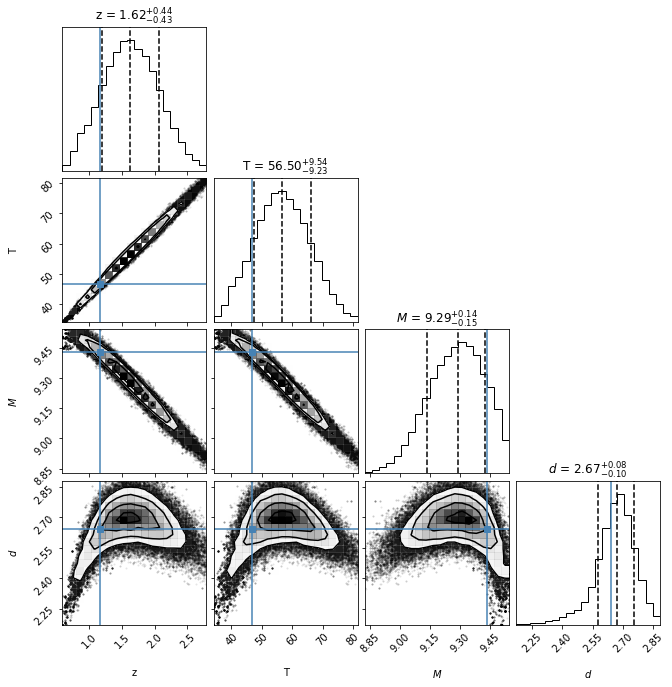

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

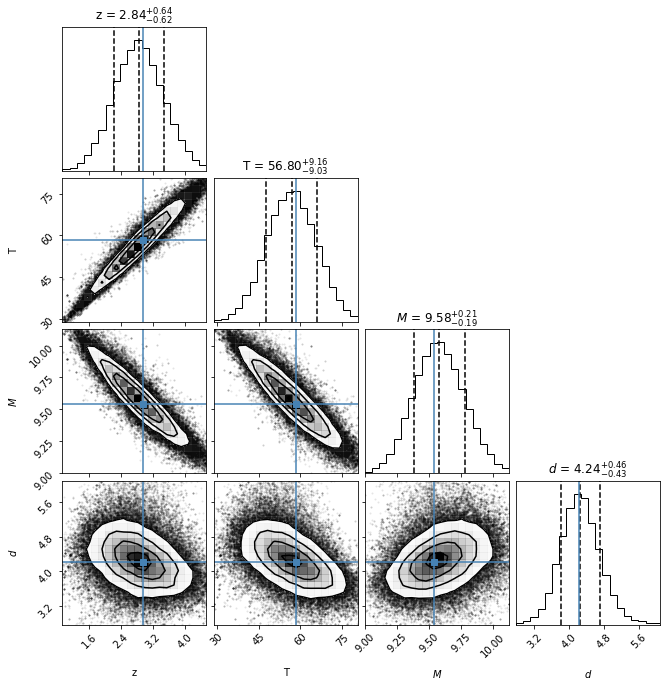

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

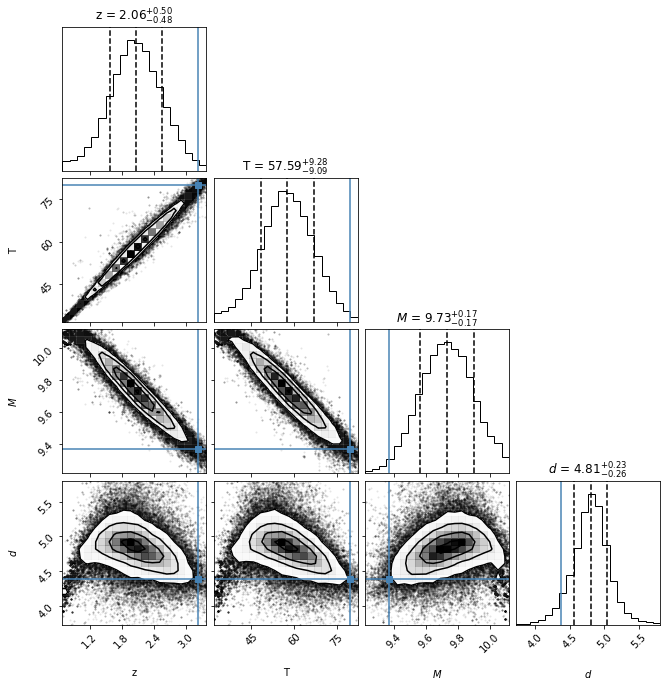

<Figure size 864x648 with 0 Axes>

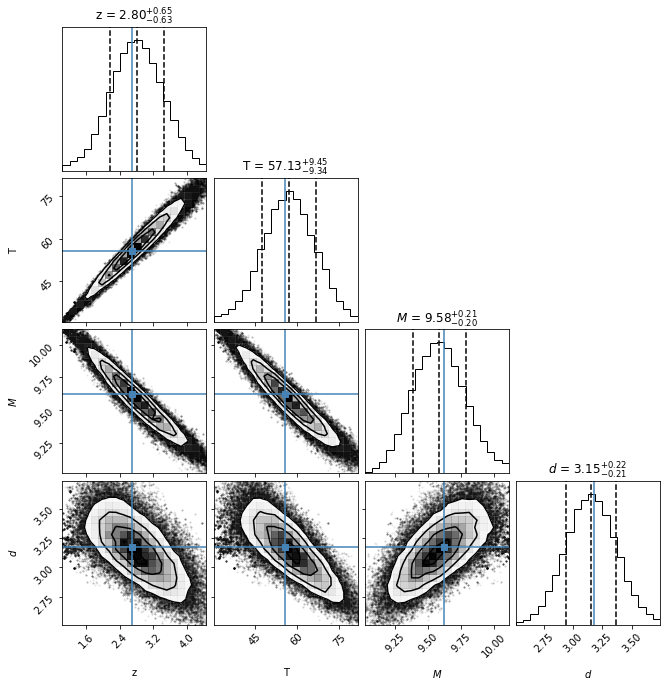

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

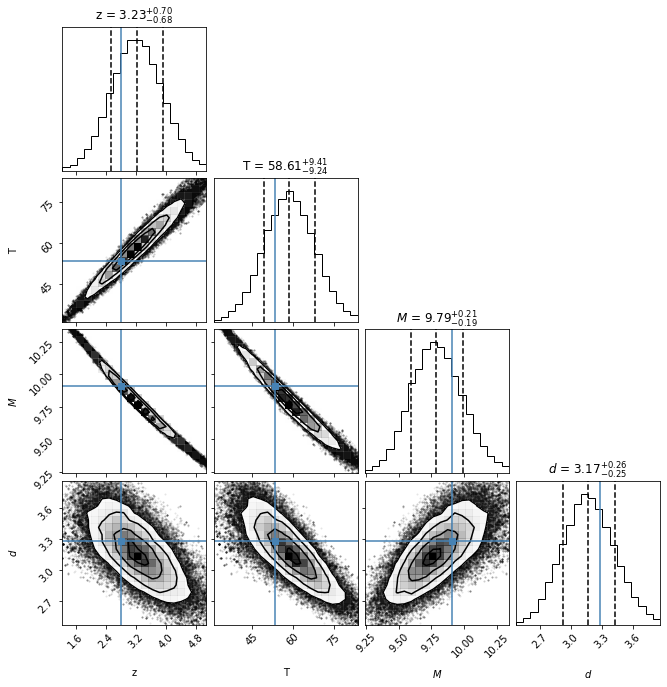

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

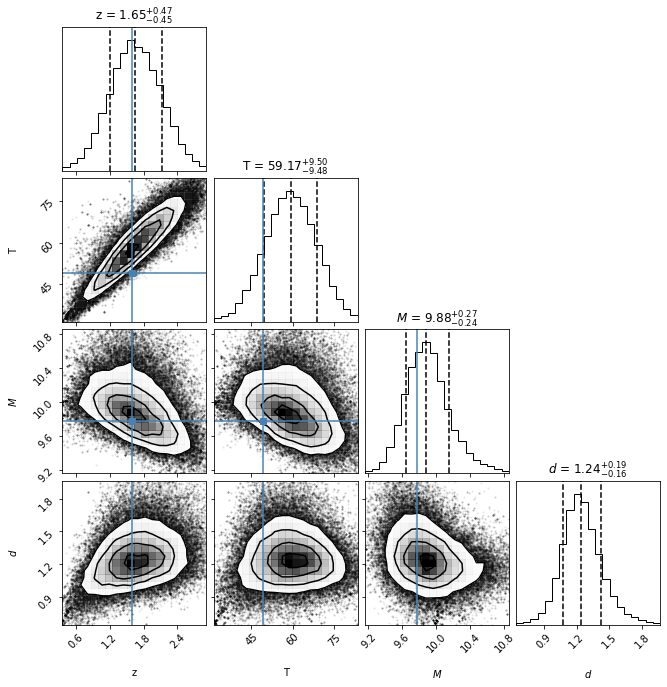

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

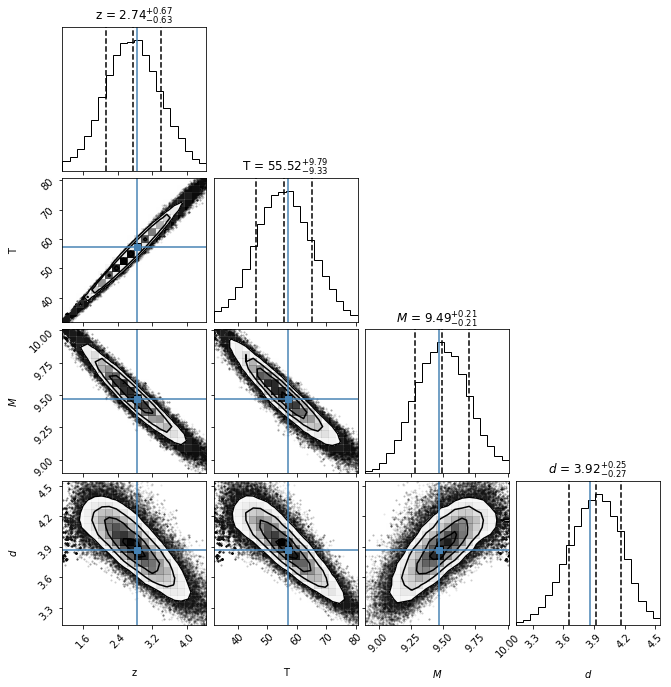

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

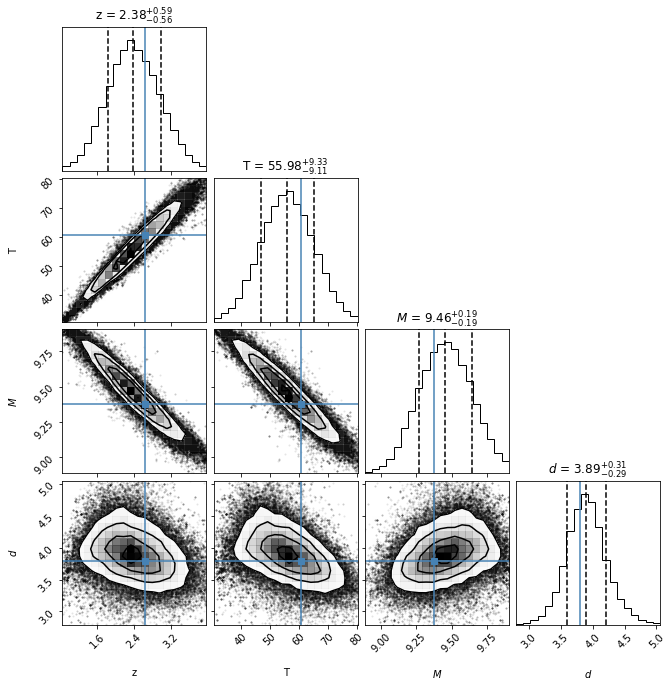

<Figure size 864x648 with 0 Axes>

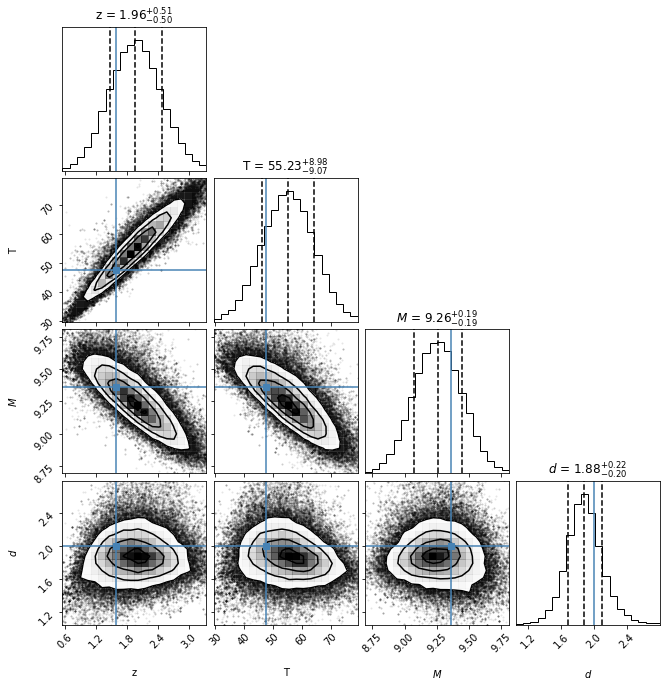

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

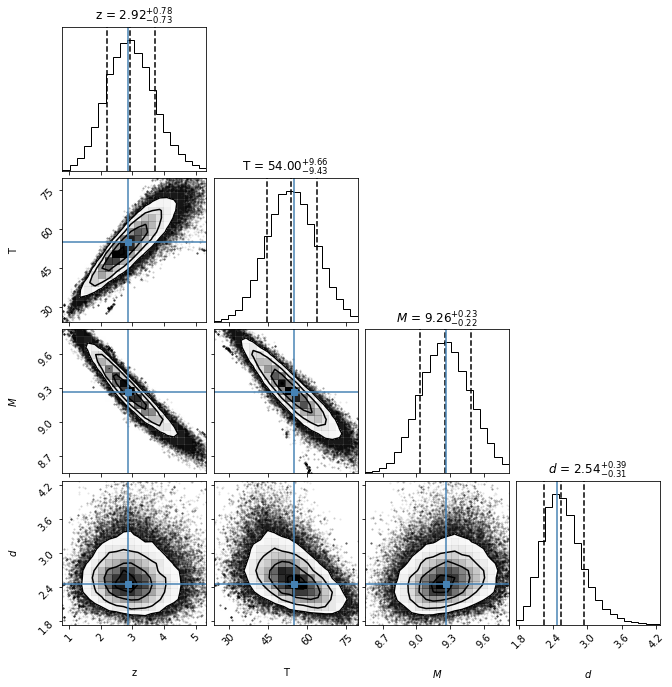

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

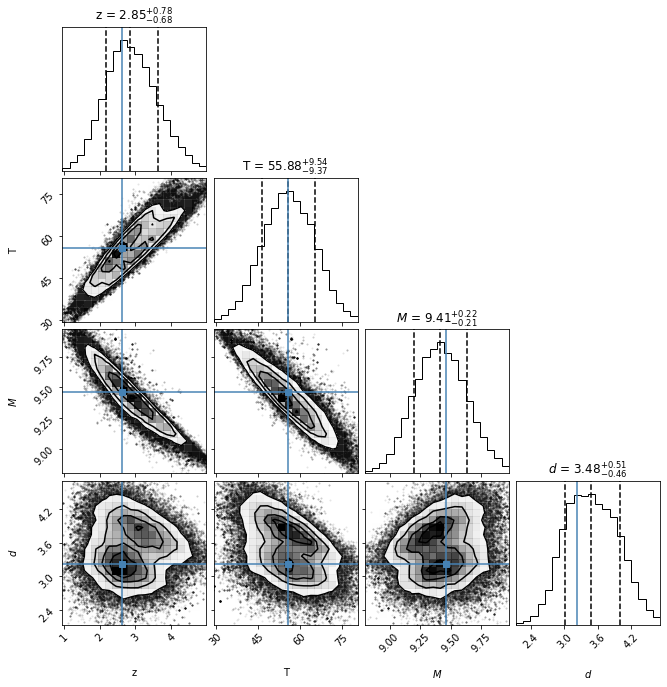

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

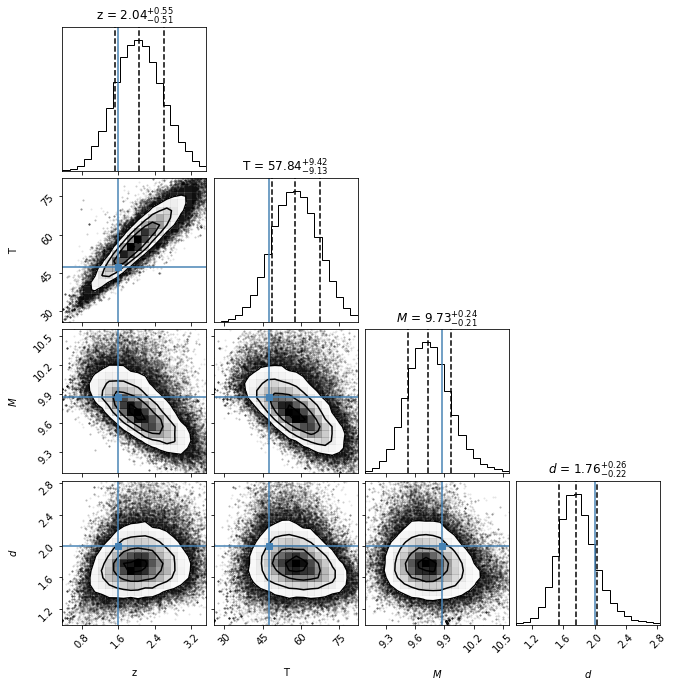

<Figure size 864x648 with 0 Axes>

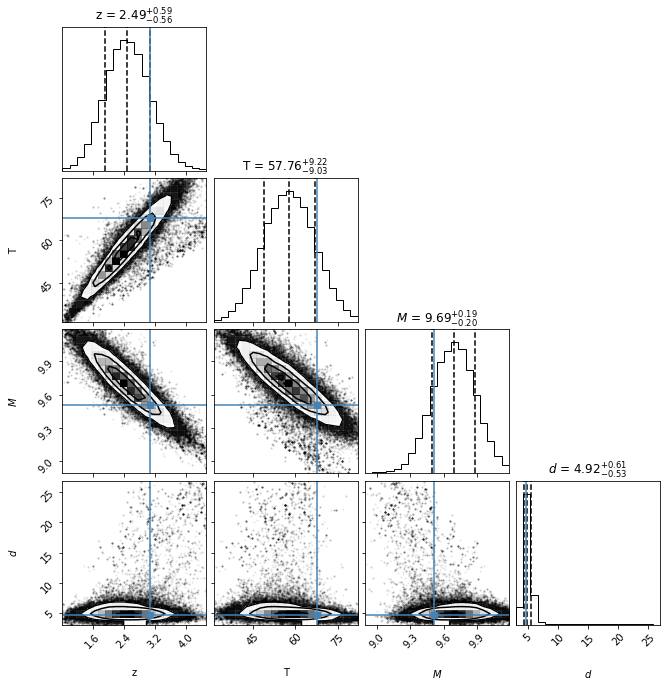

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

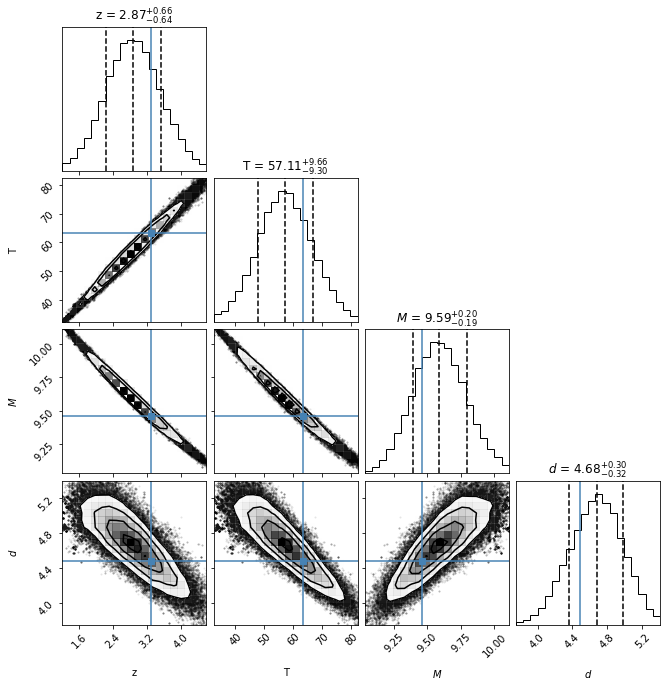

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

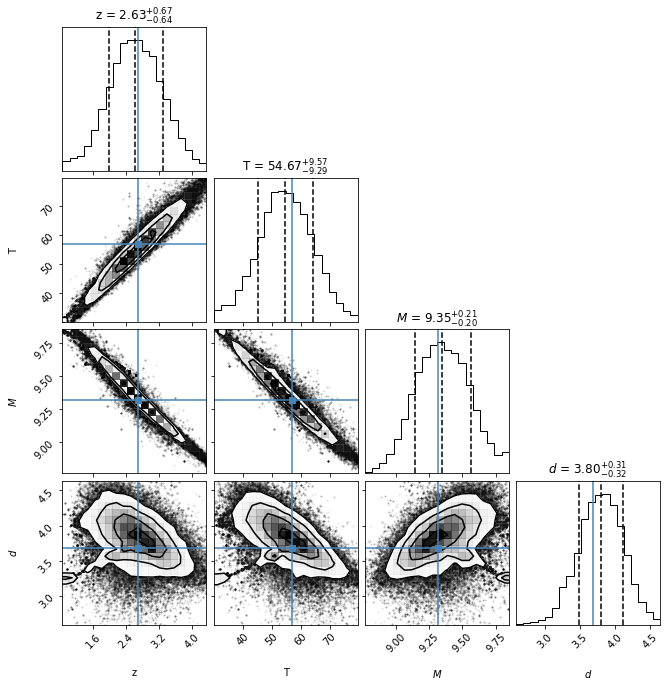

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

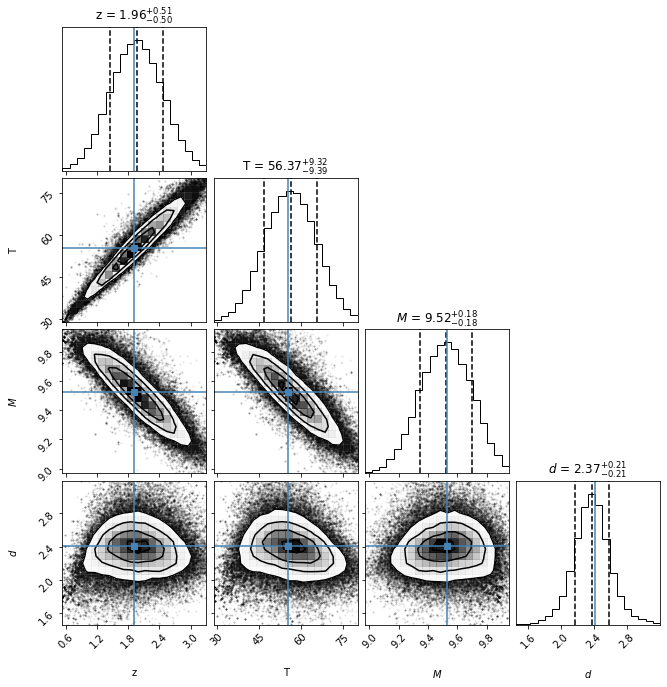

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

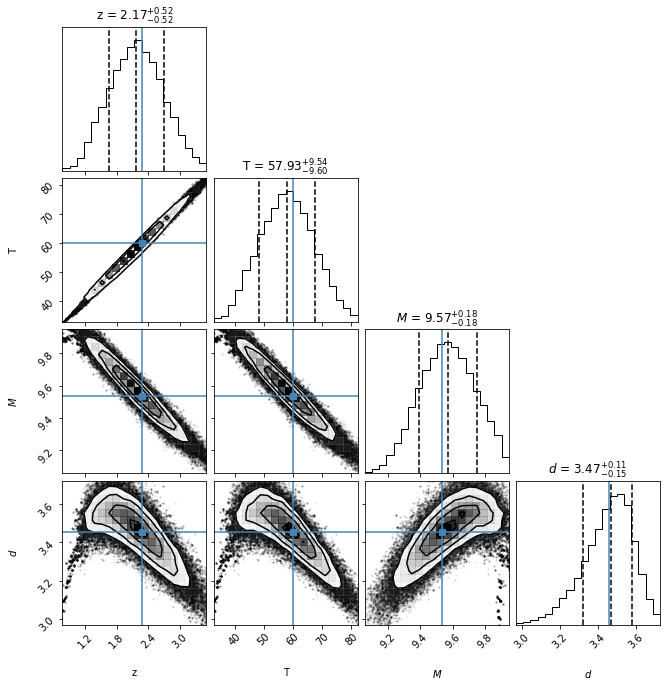

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

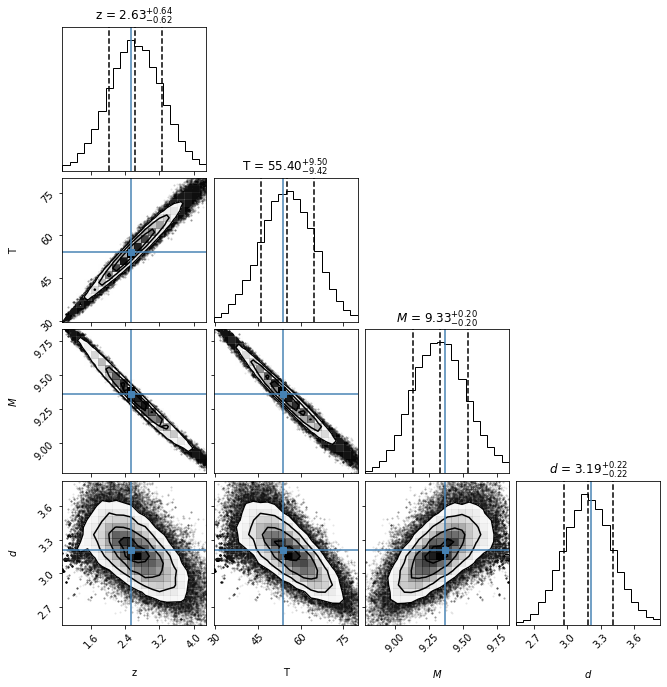

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

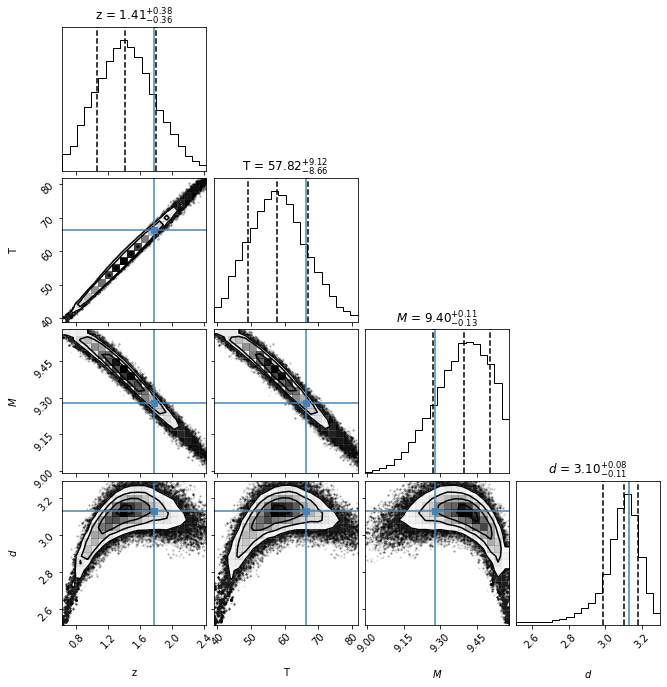

<Figure size 864x648 with 0 Axes>

In [106]:
z_mcmcT_36=[] #todos los redshift
T_mcmcT_36=[]
M_mcmcT_36=[]
d_mcmcT_36=[]
i_mcmcT_36=[]
ID_mcmcT_36=[]

for i in range(len(rows)):
    print(i)
    try:
        modeloS_36= mcmc_S(ID[i],frecsT_l[i],errfT_l[i],"S",36)
        z_mcmcT_36.append(modeloS_36[0])
        T_mcmcT_36.append(modeloS_36[1])
        M_mcmcT_36.append(modeloS_36[2])
        d_mcmcT_36.append(modeloS_36[3])
        i_mcmcT_36.append(i)
        ID_mcmcT_36.append(ID[i])
    except:
        pass
    
print(z_mcmcT_36)
print(T_mcmcT_36)
print(M_mcmcT_36)
print(d_mcmcT_36)
print(i_mcmcT_36)
print(ID_mcmcT_36)

In [22]:
zspec_36 = []
zmcmc_36=[]
Tmcmc_36 =[]
Mmcmc_36=[]
dmcmc_36=[]

In [23]:
for item in i_mcmcT_36:
    zspec_36.append(z[item])

In [24]:
for (i,j,k,l) in zip(z_mcmcT_36,T_mcmcT_36,M_mcmcT_36,d_mcmcT_36):
    for (m,n,o,p) in zip(i,j,k,l):
        zmcmc_36.append(m[0])
        Tmcmc_36.append(n[0])
        Mmcmc_36.append(o[0])
        dmcmc_36.append(p[0])

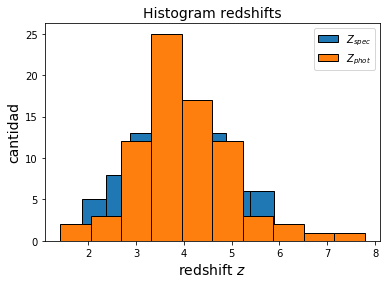

In [25]:
plt.hist(zspec_36,bins=10,edgecolor="k",label="$Z_{spec}$")
plt.hist(zmcmc_36,bins=10,edgecolor="k",label="$Z_{phot}$")
plt.title("Histogram redshifts",fontsize=14)
plt.xlabel("redshift $z$",fontsize=14)
plt.ylabel("cantidad",fontsize=14)
plt.legend()

Text(0.5, 0, '$z_{phot}$')

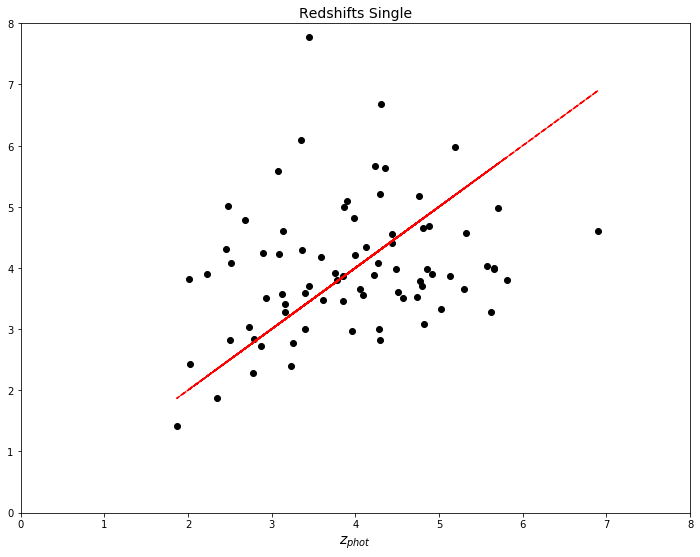

In [26]:
plt.figure(figsize=(12,9))

plt.scatter(zspec_36,zmcmc_36,c="k",marker="o")
plt.xlim([0,8])
plt.ylim([0,8])
plt.plot(zspec_36,zspec_36,c="r",ls="--")

plt.title("Redshifts Single",fontsize=14)
plt.xlabel(r"$z_{esp}$",fontsize=14)
plt.xlabel(r"$z_{phot}$",fontsize=14)

Text(0.5, 0, '$z_{phot}$')

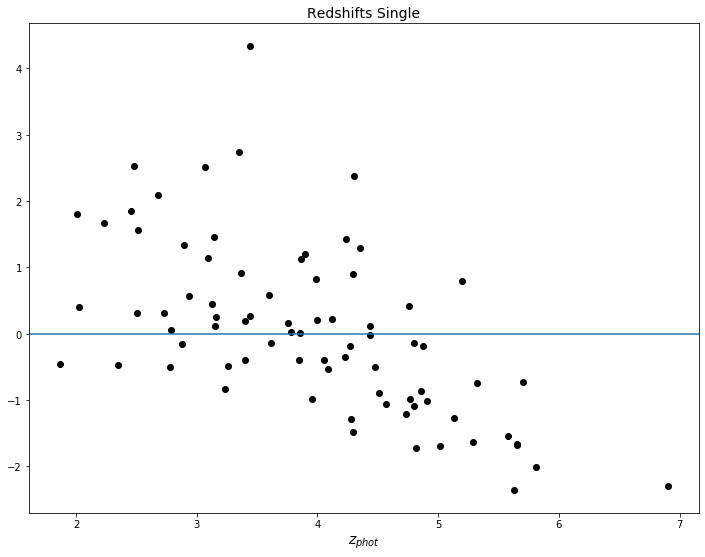

In [30]:
plt.figure(figsize=(12,9))

plt.scatter(zspec_36,np.array(zmcmc_36)-np.array(zspec_36),c="k",marker="o")
plt.axhline(0)

plt.title("Redshifts Single",fontsize=14)
plt.xlabel(r"$z_{esp}$",fontsize=14)
plt.xlabel(r"$z_{phot}$",fontsize=14)

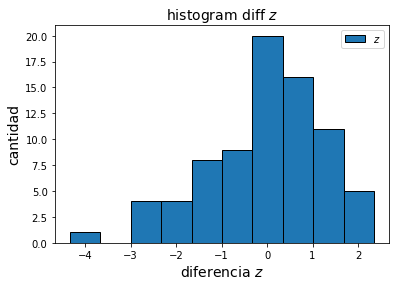

In [31]:
plt.hist(np.array(zspec_36)-np.array(zmcmc_36),bins=10,edgecolor="k",label="$z$")
plt.title("histogram diff $z$",fontsize=14)
plt.xlabel("diferencia $z$",fontsize=14)
plt.ylabel("cantidad",fontsize=14)
plt.legend()

In [32]:
np.std(np.array(zspec_36)-np.array(zmcmc_36))

1.2715881394638324

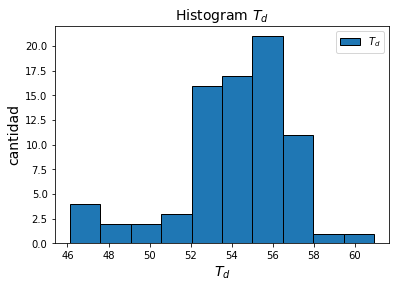

In [33]:
plt.hist(Tmcmc_36,bins=10,edgecolor="k",label="$T_{d}$")
plt.title("Histogram $T_{d}$",fontsize=14)
plt.xlabel("$T_{d}$",fontsize=14)
plt.ylabel("cantidad",fontsize=14)
plt.legend()

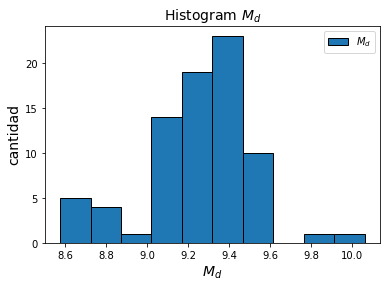

In [34]:
plt.hist(Mmcmc_36,bins=10,edgecolor="k",label="$M_{d}$")
plt.title("Histogram $M_{d}$",fontsize=14)
plt.xlabel("$M_{d}$",fontsize=14)
plt.ylabel("cantidad",fontsize=14)
plt.legend()

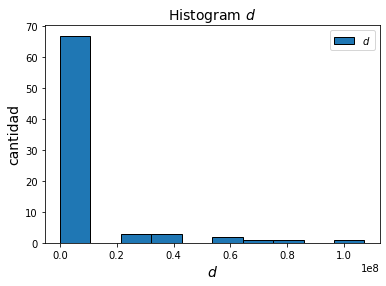

In [35]:
plt.hist(dmcmc_36,bins=10,edgecolor="k",label="$d$")
plt.title("Histogram $d$",fontsize=14)
plt.xlabel("$d$",fontsize=14)
plt.ylabel("cantidad",fontsize=14)
plt.legend()